# Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import random as rd
import os
from tqdm import tqdm
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar


plt.style.use(['science','ieee'])

2022-06-23 11:51:46.157046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 11:51:46.157072: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Oracle

In [2]:
#GeV [min,max]

tanB_range = [2, 60]
mu_range = [-10**4, 10**4]
M1_range = M2_range = M3_range = [50, 5000]
mA_range = [50, 5000]

mQ_ii_range = mu_ii_range = md_ii_range = mL_ii_range = me_ii_range = [10**2,10**7]
ae_33_range = [-10**4,10**4]
au_ii_range = ad_ii_range = [-10**4,10**4]
mQ_23_range = [0,10**3]
md_23_range = [0,10**3]
au_ij_range = ad_ij_range = [-100,100]

NMFV_range_big= [tanB_range, mu_range, M1_range, M2_range, M3_range, mA_range, mQ_ii_range,
                 mQ_ii_range, mQ_ii_range, mu_ii_range, mu_ii_range, mu_ii_range, md_ii_range,
                 md_ii_range, md_ii_range, mL_ii_range, mL_ii_range, mL_ii_range, me_ii_range,
                 me_ii_range, me_ii_range, ae_33_range, au_ii_range, au_ii_range, au_ii_range,
                 ad_ii_range, ad_ii_range, ad_ii_range, mQ_23_range, md_23_range, au_ij_range,
                 au_ij_range, au_ij_range, au_ij_range, au_ij_range, au_ij_range, ad_ij_range,
                 ad_ij_range, ad_ij_range, ad_ij_range, ad_ij_range, ad_ij_range]


NMFV_min = np.array([i[0] for i in NMFV_range_big])
NMFV_max = np.array([i[1] for i in NMFV_range_big])

NMFV_sub = np.subtract(NMFV_max, NMFV_min)

NMFV_range = [NMFV_min,NMFV_max,NMFV_sub]

In [3]:
def write_slha(NMFV, nom_slha):
    f = open(nom_slha, "w")
    
    f.write("BLOCK MODSEL \n")
    f.write(" 1    0                               #MSSM \n")
    f.write(" 6    1                               #flavour violation \n")
                                                    
    f.write("BLOCK SMINPUTS \n")                    
    f.write("  1   1.27931417e+02                  # alpha^(-1) SM MSbar(M1) \n")
    f.write("  2   1.663900000e-05                 # G_Fermi \n")
    f.write("  3   0.119                           # alphas(MS) SM MSbar \n")
    f.write("  4   91.1876                         # MZ(pole) \n")
    f.write("  5   4.18                            # mb(mb) SM MSbar \n")
    f.write("  6   172.9                           # mtop(pole) \n")
    f.write("  7   1.776860000e+00                 # m mtau(pole) \n")
                                                      
    f.write("BLOCK MINPAR \n")                     
    f.write("  3   "+str(NMFV[0])+"                # tanb \n")
    f.write("  4   1                               # sign mu \n")
                                                   
    f.write("BLOCK EXTPAR \n")                    
    f.write("  0    "+str(-1.0)+"                  # Q \n")
    f.write("  1    "+str(NMFV[2])+"               # M1 \n")
    f.write("  2    "+str(NMFV[3])+"               # M2 \n")
    f.write("  3    "+str(NMFV[4])+"               # M3 \n")
    f.write("  23   "+str(NMFV[1])+"               # mu \n")
    f.write("  26   "+str(NMFV[5])+"               # mA \n")
    f.write("  25   "+str(NMFV[0])+"               # tanb \n")
    
    f.write("BLOCK MSQ2IN \n")                            
    f.write("  1  1    "+str(NMFV[6])+"            # mq2_11 \n")
    f.write("  2  1    "+str(0)+"                  # mq2_12 \n")
    f.write("  3  1    "+str(0)+"                  # mq2_13 \n")
    f.write("  1  2    "+str(0)+"                  # mq2_21 \n")
    f.write("  2  2    "+str(NMFV[7])+"            # mq2_22 \n")
    f.write("  3  2    "+str(0)+"                  # mq2_23 \n")
    f.write("  1  3    "+str(0)+"                  # mq2_31 \n")
    f.write("  2  3    "+str(NMFV[28])+"           # mq2_32 \n")
    f.write("  3  3    "+str(NMFV[8])+"            # mq2_33 \n")
    
    f.write("BLOCK MSU2IN \n")                            
    f.write("  1  1    "+str(NMFV[9])+"            # mu2_11 \n")
    f.write("  2  1    "+str(0)+"                  # mu2_12 \n")
    f.write("  3  1    "+str(0)+"                  # mu2_13 \n")
    f.write("  1  2    "+str(0)+"                  # mu2_21 \n")
    f.write("  2  2    "+str(NMFV[10])+"           # mu2_22 \n")
    f.write("  3  2    "+str(0)+"                  # mu2_23 \n")
    f.write("  1  3    "+str(0)+"                  # mu2_31 \n")
    f.write("  2  3    "+str(0)+"                  # mu2_32 \n")
    f.write("  3  3    "+str(NMFV[11])+"           # mu2_33 \n")
    
    f.write("BLOCK MSD2IN \n")                            
    f.write("  1  1    "+str(NMFV[12])+"           # md2_11 \n")
    f.write("  2  1    "+str(0)+"                  # md2_12 \n")
    f.write("  3  1    "+str(0)+"                  # md2_13 \n")
    f.write("  1  2    "+str(0)+"                  # md2_21 \n")
    f.write("  2  2    "+str(NMFV[13])+"           # md2_22 \n")
    f.write("  3  2    "+str(0)+"                  # md2_23 \n")
    f.write("  1  3    "+str(0)+"                  # md2_31 \n")
    f.write("  2  3    "+str(NMFV[29])+"           # md2_32 \n")
    f.write("  3  3    "+str(NMFV[14])+"           # md2_33 \n")
    
    f.write("BLOCK MSL2IN \n")                            
    f.write("  1  1    "+str(NMFV[15])+"           # ml2_11 \n")
    f.write("  2  1    "+str(0)+"                  # ml2_12 \n")
    f.write("  3  1    "+str(0)+"                  # ml2_13 \n")
    f.write("  1  2    "+str(0)+"                  # ml2_21 \n")
    f.write("  2  2    "+str(NMFV[16])+"           # ml2_22 \n")
    f.write("  3  2    "+str(0)+"                  # ml2_23 \n")
    f.write("  1  3    "+str(0)+"                  # ml2_31 \n")
    f.write("  2  3    "+str(0)+"                  # ml2_32 \n")
    f.write("  3  3    "+str(NMFV[17])+"           # ml2_33 \n")
    
    f.write("BLOCK MSE2IN \n")                            
    f.write("  1  1    "+str(NMFV[18])+"           # me2_11 \n")
    f.write("  2  1    "+str(0)+"                  # me2_12 \n")
    f.write("  3  1    "+str(0)+"                  # me2_13 \n")
    f.write("  1  2    "+str(0)+"                  # me2_21 \n")
    f.write("  2  2    "+str(NMFV[19])+"           # me2_22 \n")
    f.write("  3  2    "+str(0)+"                  # me2_23 \n")
    f.write("  1  3    "+str(0)+"                  # me2_31 \n")
    f.write("  2  3    "+str(0)+"                  # me2_32 \n")
    f.write("  3  3    "+str(NMFV[20])+"           # me2_33 \n")
    
    f.write("BLOCK TEIN \n")                            
    f.write("  1  1    "+str(0)+"                  # T_e_11 \n")
    f.write("  2  1    "+str(0)+"                  # T_e_21 \n")
    f.write("  3  1    "+str(0)+"                  # T_e_31 \n")
    f.write("  1  2    "+str(0)+"                  # T_e_12 \n")
    f.write("  2  2    "+str(0)+"                  # T_e_22 \n")
    f.write("  3  2    "+str(0)+"                  # T_e_32 \n")
    f.write("  1  3    "+str(0)+"                  # T_e_13 \n")
    f.write("  2  3    "+str(0)+"                  # T_e_23 \n")
    f.write("  3  3    "+str(NMFV[21])+"           # T_e_33 \n")
    
    f.write("BLOCK TUIN \n")                            
    f.write("  1  1    "+str(NMFV[22])+"           # T_u_11 \n")
    f.write("  2  1    "+str(NMFV[30])+"           # T_u_21 \n")
    f.write("  3  1    "+str(NMFV[31])+"           # T_u_31 \n")
    f.write("  1  2    "+str(NMFV[32])+"           # T_u_12 \n")
    f.write("  2  2    "+str(NMFV[23])+"           # T_u_22 \n")
    f.write("  3  2    "+str(NMFV[33])+"           # T_u_32 \n")
    f.write("  1  3    "+str(NMFV[34])+"           # T_u_13 \n")
    f.write("  2  3    "+str(NMFV[35])+"           # T_u_23 \n")
    f.write("  3  3    "+str(NMFV[24])+"           # T_u_33 \n")
    
    f.write("BLOCK TDIN \n")                            
    f.write("  1  1    "+str(NMFV[25])+"           # T_d_11 \n")
    f.write("  2  1    "+str(NMFV[36])+"           # T_d_21 \n")
    f.write("  3  1    "+str(NMFV[37])+"           # T_d_31 \n")
    f.write("  1  2    "+str(NMFV[38])+"           # T_d_12 \n")
    f.write("  2  2    "+str(NMFV[26])+"           # T_d_22 \n")
    f.write("  3  2    "+str(NMFV[39])+"           # T_d_32 \n")
    f.write("  1  3    "+str(NMFV[40])+"           # T_d_13 \n")
    f.write("  2  3    "+str(NMFV[41])+"           # T_d_23 \n")
    f.write("  3  3    "+str(NMFV[27])+"           # T_d_33 \n")
    
    f.close()

0.01110899653824131
1.0
0.6065306597126273


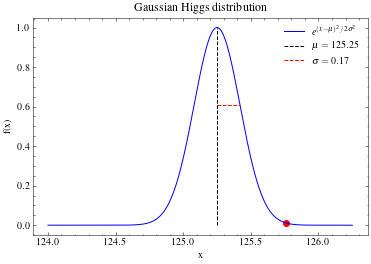

In [22]:
def Gauss(mu_gauss,sigma_gauss,x):
    return np.exp(-0.5*((x-mu_gauss)/sigma_gauss)**2)

mu_gauss = 125.25
sigma_gauss = 0.17

x = np.linspace(124,126.25,1000)
y = [Gauss(mu_gauss,sigma_gauss,i) for i in x]
plt.plot(x,y,'-b',label=r'$e^{(x-\mu)^2 / 2\sigma^2}$')
plt.plot([125.25,125.25],[0,1],'--k',label=r'$\mu = 125.25$')
plt.plot([125.25,125.25+0.17],[Gauss(mu_gauss,sigma_gauss,mu_gauss+sigma_gauss),
                               Gauss(mu_gauss,sigma_gauss,mu_gauss+sigma_gauss)],
        '--r',label=r'$\sigma = 0.17$')
plt.plot(mu_gauss+3*sigma_gauss,Gauss(mu_gauss,sigma_gauss,mu_gauss+3*sigma_gauss),'or')
plt.plot(mu_gauss+3*sigma_gauss,Gauss(mu_gauss,sigma_gauss,mu_gauss+3*sigma_gauss),'or',
        label='$3\sig:')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gaussian Higgs distribution')
plt.legend()


print(Gauss(mu_gauss,sigma_gauss,mu_gauss+3*sigma_gauss))
print(Gauss(mu_gauss,sigma_gauss,mu_gauss))
print(Gauss(mu_gauss,sigma_gauss,mu_gauss+sigma_gauss))

gauss_3sigma = Gauss(mu_gauss,sigma_gauss,mu_gauss+3*sigma_gauss)

In [5]:
def Oracle(logits, NMFV_range, ratio, succes_path):
    
    NMFV_AL = np.add(np.multiply(logits,NMFV_range[2]),NMFV_range[0])
    
    write_slha(NMFV_AL, "Advanced NN/NMFV/nmfv_al.in")    
    
    os.system('./SUSY/softsusy-4.1.9/softpoint.x leshouches < Advanced\ NN/NMFV/nmfv_al.in > Advanced\ NN/NMFV/nmfv_al.out')
            
          
    if os.path.getsize('/home/mathis/Stage M1/Advanced NN/NMFV/nmfv_al.out') == 0 :
        ratio[0]+=1
        return 0
        
    with open('Advanced NN/NMFV/nmfv_al.out') as slha_out:
        content = slha_out.read()
        if 'SOFTSUSY problem' in content:
            ratio[0]+=1
            return 0
        if 'LSP # Warning' in content:
            ratio[0]+=1
            return 0
    
    with open('Advanced NN/NMFV/nmfv_al.out') as file:
        for indice, ligne in enumerate(file):
            if '# h0' in ligne:
                h0_value = float(ligne.split()[1])
    
    h0_gauss = Gauss(mu_gauss,sigma_gauss,h0_value)
    
    if h0_gauss < gauss_3sigma:
        ratio[0]+=1
        return 0
    else:
        ratio[1]+=1
        commande = 'mv Advanced\ NN/NMFV/nmfv_al.out '
        nom_fichier = 'nmfv_al_succes_'+str(ratio[1])+'.out'
        os.system(commande+succes_path+nom_fichier)
        return h0_gauss   

# Model

In [6]:
fnc_activation = 'relu'
fnc_activation_output = 'sigmoid'
inputs = tf.keras.Input(shape=(42,), dtype='float32')
x = keras.layers.Dense(100, trainable=True, activation=fnc_activation)(inputs)
x = keras.layers.Dense(100, trainable=True, activation=fnc_activation)(x)
outputs = keras.layers.Dense(1, activation=fnc_activation_output)(x)
model = tf.keras.Model(inputs,outputs)

lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.summary()



loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='sum_over_batch_size')
#False pour une probabilité ie [0;1]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 dense (Dense)               (None, 100)               4300      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 14,501
Trainable params: 14,501
Non-trainable params: 0
_________________________________________________________________


2022-06-21 15:07:13.187120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-21 15:07:13.187153: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-21 15:07:13.187178: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MPC): /proc/driver/nvidia/version does not exist
2022-06-21 15:07:13.187489: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initial training

In [7]:
os.chdir('/home/mathis/Stage M1/')
os.system('rm -r Advanced\ NN/NMFV/softsusy_succes/')
os.system('mkdir -p Advanced\ NN/NMFV/softsusy_succes')
succes_path = 'Advanced\ NN/NMFV/softsusy_succes/'

ratio = [0,0]

L_size = 500000
K_size = 1000
train_step = 1

a = 0.0001
alpha = 0.5

K_pool = []
K_pred = []

compteur = 0
full_train = 0

q = 1

for step , i in enumerate(range(train_step)):
    print('Step {} / {}'.format(i+1,train_step))
    
    p = 2*min(q,0.5)
    p = round(p,1)
    
    if p == 1:
        K = [[rd.uniform(0,1) for j in range(42)] for k in range(K_size)]
    
    if p < 1:
        print('   Recherche points')
        pK_size = int(K_size*p)
        pm1 = round((1-p),1)
        
        pK = [[rd.uniform(0,1) for j in range(42)] for k in range(pK_size)]
        
        L = [[rd.uniform(0,1) for j in range(42)] for k in range(L_size)]
        L = tf.convert_to_tensor(L)
        L_logits = model(tf.convert_to_tensor(L))

        s = tf.math.multiply(L_logits,tf.math.subtract(1,L_logits))
        index = tf.math.argmax(s, axis=0).numpy()[0]

        K = []
        K.append(L[index].numpy().tolist())
        s = tf.concat([s[0:index], s[index+1:len(s)]],0)
        L = tf.concat([L[0:index], L[index+1:len(L)]],0)


        rj_tensor = tf.zeros([len(s),1])
        for j in range(int(pm1*K_size)-1):

            ri = tf.convert_to_tensor(K[-1])
            ri = tf.math.multiply(tf.ones([len(s),1]),ri)

            dabs = tf.math.abs(tf.math.subtract(ri,L))
            dsquared = tf.math.multiply(dabs, dabs)
            dsquared = tf.reduce_mean(dsquared, axis=1)

            rj_list = dsquared.numpy()
            rj_list = np.where(rj_list<0.01**2, -a/(a+rj_list), rj_list*0)
            rj_min = np.amin(rj_list)

            rj_list = tf.convert_to_tensor([rj_list])
            rj_list = tf.transpose(rj_list)
            rj_tensor = tf.math.add(rj_tensor,rj_list)

            sigma = s.numpy().std() 

            S_part1 = tf.math.multiply((1-alpha),s)
            S_part2 = tf.math.multiply((alpha*sigma/(4*rj_min)),rj_tensor)
            S = tf.math.add(S_part1 , S_part2)

            index2 = tf.math.argmax(S, axis=0).numpy()[0]

            K.append(L[index2].numpy().tolist())

            s = tf.concat([s[0:index2], s[index2+1:len(s)]],0)
            L = tf.concat([L[0:index2], L[index2+1:len(L)]],0)
            rj_tensor = tf.concat([rj_tensor[0:index2], rj_tensor[index2+1:len(rj_tensor)]],0)
        
        K = K + pK
        
    assert len(K) == K_size
    K_pool.append(K)
    
    pred_liste = []
    print('   Verite')
    for j in tqdm(K):
        pred = Oracle(j, NMFV_range, ratio, succes_path)
        pred_liste.append(pred)
    
    assert len(pred_liste) == K_size
    K_pred.append(pred_liste)     
    
    batch_pred = [K_pred[-1]]
    all_batch = [K_pool[-1]]
    '''
    if compteur == full_train:
        compteur = 0
        all_batch = K_pool
        batch_pred = K_pred
    '''
    
    print('   Optimisation')
    for j in range(len(all_batch)): 
        with tf.GradientTape() as tape:
            logits = model(tf.convert_to_tensor(all_batch[j]))

            true = tf.convert_to_tensor([batch_pred[j]])
            true = tf.transpose(true)
            
            true_prime = tf.cast(true, dtype=tf.float32)
            q = tf.math.abs(tf.math.subtract(true_prime,logits))
            q = tf.reduce_mean(q, axis=0)
            q = round(q.numpy()[0],1)
            
            loss = loss_fn(true,logits)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    compteur += 1
    
    
print("Nombre d'échecs:",ratio[0])
print("Nombre de succes:",ratio[1])

Step 1 / 1
   Verite


100%|███████████████████████████████████████| 1000/1000 [01:31<00:00, 10.90it/s]


   Optimisation
Nombre d'échecs: 999
Nombre de succes: 1


# Récupération data

In [8]:
def recuperation_slha(folder,filename,sus_mass,param,ms2_param,t_param,succes):
    warning = 0
    for j in range(succes):
        file_name =folder+filename+str(j+1)+'.out' 
        
        with open(file_name) as file:
            for indice, ligne in enumerate(file):
                if 'tanb' in ligne:
                    indice_tanb = indice
                
                if 'M_1(MX)' in ligne:
                    indices_M = [indice+i for i in range(3)]
                if 'mu(MX)' in ligne:
                    indice_mu = indice
                if 'mA(pole)' in ligne:
                    indice_mA = indice
                    
                if 'MW' in ligne:
                    indices_masses = [indice+i for i in range(33)]
                    
                if 'input (mhat_Q^2)_{1,1}' in ligne:
                    indices_msq2 = [indice, indice+3, indice+4, indice+5]
                if 'input (mhat_u^2)_{1,1}' in ligne:
                    indices_msu2 = [indice, indice+3, indice+5]
                if 'input (mhat_d^2)_{1,1}' in ligne:
                    indices_msd2 = [indice, indice+3, indice+4, indice+5]
                if 'Block MSL2IN' in ligne:
                    indices_msl2 = [indice+1, indice+4, indice+6]
                if 'Block MSE2IN' in ligne:
                    indices_mse2 = [indice+1, indice+4, indice+6]
                    
                if 'input (That_U)_{1,1}' in ligne:
                    indices_tu = [indice+i for i in range(9)]
                if 'input (That_D)_{1,1}' in ligne:
                    indices_td = [indice+i for i in range(9)]
                if 'input (That_E)_{3,3}' in ligne:
                    indice_te = indice
        
        
        file = open(file_name)
        lignes = file.readlines()
        
        
        param[0].append(float(lignes[indice_tanb].split()[1]))
        
        for step, i in enumerate(param[1]):
            i.append(float(lignes[indices_M[step]].split()[1]))
            
        param[2].append(float(lignes[indice_mu].split()[1]))
        
        param[3].append(float(lignes[indice_mA].split()[1]))
            
        
            
        
        sus_mass[0].append(float(lignes[indices_masses[0]].split()[1]))
        
        for step, i in enumerate(sus_mass[1]):
            i.append(float(lignes[indices_masses[step+1]].split()[1]))
        
        sus_mass[2].append(float(lignes[indices_masses[5]].split()[1]))
        
        sus_mass[3][0].append(float(lignes[indices_masses[6]].split()[1]))
        sus_mass[3][1].append(float(lignes[indices_masses[7]].split()[1]))
        sus_mass[3][2].append(float(lignes[indices_masses[9]].split()[1]))
        sus_mass[3][3].append(float(lignes[indices_masses[10]].split()[1]))
        
        sus_mass[4][0].append(float(lignes[indices_masses[8]].split()[1]))
        sus_mass[4][1].append(float(lignes[indices_masses[11]].split()[1]))
        
        for step, i in enumerate(sus_mass[5]):
            i.append(float(lignes[indices_masses[step+12]].split()[1]))
        
        for step, i in enumerate(sus_mass[6]):
            i.append(float(lignes[indices_masses[step+18]].split()[1]))

        for step, i in enumerate(sus_mass[7]):
            i.append(float(lignes[indices_masses[step+21]].split()[1]))        
        
        for step, i in enumerate(sus_mass[8]):
            i.append(float(lignes[indices_masses[step+27]].split()[1]))
            
            
            
        for step, i in enumerate(ms2_param[0]):
            i.append(float(lignes[indices_msq2[step]].split()[2]))
        for step, i in enumerate(ms2_param[1]):
            i.append(float(lignes[indices_msu2[step]].split()[2]))    
        for step, i in enumerate(ms2_param[2]):
            i.append(float(lignes[indices_msd2[step]].split()[2]))
        for step, i in enumerate(ms2_param[3]):
            i.append(float(lignes[indices_msl2[step]].split()[2]))
        for step, i in enumerate(ms2_param[4]):
            i.append(float(lignes[indices_mse2[step]].split()[2])) 
            
            
            
        for step, i in enumerate(t_param[0]):
            i.append(float(lignes[indices_tu[step]].split()[2]))
        for step, i in enumerate(t_param[1]):
            i.append(float(lignes[indices_td[step]].split()[2])) 
        t_param[2].append(float(lignes[indice_te].split()[2]))
    
    
    
        with open(file_name) as file:
            if 'LSP # Warning' in file.read():
                warning+=1
    return warning

In [9]:
MW_mass = []
higgs_mass = [[] for i in range(4)]        #[h0 , H0 , A0 , H+]
g_mass = []
neutralino_mass = [[] for i in range(4)]   #[N1 , N2 , N3 , N4]
chargino_mass = [[] for i in range(2)]     #[neutralino1 , neutralino2]     
e_mass = [[] for i in range(6)]
nu_mass = [[] for i in range(3)]
d_mass = [[] for i in range(6)]
u_mass = [[] for i in range(6)]

sus_mass = [MW_mass,higgs_mass,g_mass,neutralino_mass,chargino_mass,e_mass,nu_mass,d_mass,u_mass]


tanB_param = []
M_param = [[] for i in range(3)]           #[M1 , M2 , M3
mu_param = []
mA_param = []

param = [tanB_param,M_param,mu_param,mA_param]


msq2_param = [[] for i in range(4)]
msu2_param = [[] for i in range(3)]
msd2_param = [[] for i in range(4)]
msl2_param = [[] for i in range(3)]
mse2_param = [[] for i in range(3)]

ms2_param = [msq2_param,msu2_param,msd2_param,msl2_param,mse2_param]


tu_param = [[] for i in range(9)]
td_param = [[] for i in range(9)]
te_param = []

t_param = [tu_param,td_param,te_param]

folder = 'Advanced NN/NMFV/softsusy_succes/'
file_name = 'nmfv_al_succes_'
warning = recuperation_slha(folder,file_name,sus_mass,param,ms2_param,t_param,ratio[1])

print('Nombre warning:',warning)

Nombre warning: 0


# Sauvegarde Run

In [10]:
from datetime import date, datetime

folder_name = str(date.today())+'-'+str(datetime.now().time().strftime("%H:%M:%S"))
commande = 'mkdir -p Advanced\ NN/NMFV/NMFV_run/'+folder_name
os.system(commande)

with open('Advanced NN/NMFV/NMFV_run/'+folder_name+'/config.txt', 'w') as f:
    f.write('L: '+str(L_size)+'\n')
    f.write('K: '+str(K_size)+'\n')
    f.write('alpha: '+str(alpha)+'\n')
    f.write('a: '+str(a)+'\n')
    f.write('train steps: '+str(train_step)+'\n')
    f.write("Nombre d'échecs: "+str(ratio[0])+'\n')
    f.write("Nombre de succes: "+str(ratio[1])+'\n')
    f.write("Nombre Warning LSP: "+str(warning)+'\n')
    f.write('\n')
    f.write("Fonctions d'activations: "+fnc_activation+'\n')
    f.write("Fonctions d'activations output: "+fnc_activation_output+'\n')
    f.write('Learning rate:'+str(lr)+'\n')
    f.write('Optimizer: '+str(optimizer)+'\n')
    f.write('\n')
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('\n')
    f.write('\n')
    f.write('Range:')
    f.write('tanB: '+str(NMFV_range_big[0])+'\n')
    f.write('mu: '+str(NMFV_range_big[1])+'\n')
    f.write('M1: '+str(NMFV_range_big[2])+'\n')
    f.write('M2: '+str(NMFV_range_big[3])+'\n')
    f.write('M3: '+str(NMFV_range_big[4])+'\n')
    f.write('mA: '+str(NMFV_range_big[5])+'\n')
    
    f.write('mQ2_ii: '+str(mQ_ii_range)+'\n')
    f.write('mQ2_23: '+str(mQ_23_range)+'\n')
    f.write('mu2_ii: '+str(mu_ii_range)+'\n')
    f.write('md2_ii: '+str(md_ii_range)+'\n')
    f.write('md2_23: '+str(md_23_range)+'\n')
    f.write('mL2_ii: '+str(mL_ii_range)+'\n')
    f.write('me2_ii: '+str(me_ii_range)+'\n')
    
    f.write('au_ii: '+str(au_ii_range)+'\n')
    f.write('au_ij: '+str(au_ij_range)+'\n')
    f.write('ad_ii: '+str(ad_ii_range)+'\n')
    f.write('ad_ij: '+str(ad_ij_range)+'\n')
    f.write('ae_33: '+str(ae_33_range)+'\n')
    
    
model.save('Advanced NN/NMFV/NMFV_run/'+folder_name+'/model.h5')
    
param_file = zip(tanB_param, M_param[0], M_param[1], M_param[2], mu_param, mA_param, 
                 msq2_param[0], msq2_param[1], msq2_param[2], msq2_param[3], msu2_param[0], 
                 msu2_param[1], msu2_param[2], msd2_param[0], msd2_param[1], msd2_param[2], 
                 msd2_param[3], msl2_param[0], msl2_param[1], msl2_param[2], mse2_param[0], 
                 mse2_param[1], mse2_param[2], tu_param[0], tu_param[1], tu_param[2], 
                 tu_param[3], tu_param[4], tu_param[5], tu_param[6], tu_param[7], tu_param[8], 
                 td_param[0], td_param[1], td_param[2], td_param[3], td_param[4], td_param[5], 
                 td_param[6], td_param[7], td_param[8], te_param)

header_param = ['tanb','M1','M2','M3','mu','mA','msq2_11','msq2_22','msq2_23','msq2_33','msu2_11',
         'msu2_22','msu2_33','msd2_11','msd2_22','msd2_23','msd2_33','msl2_11','msl2_22',
         'msl2_33','mse2_11','mse2_22','mse2_33','tu_11','tu_12','tu_13','tu_21','tu_22',
         'tu_23','tu_31','tu_32','tu_33','td_11','td_12','td_13','td_21','td_22',
         'td_23','td_31','td_32','td_33','te_33']


import csv
with open('Advanced NN/NMFV/NMFV_run/'+folder_name+'/data.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(header_param)
    writer.writerows(param_file)

K_file = []

for indice_i,i in enumerate(K_pool):
    for indice_j,j in enumerate(i):
        K_file.append(j+[K_pred[indice_i][indice_j]])

with open('Advanced NN/NMFV/NMFV_run/'+folder_name+'/K_pool.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(header_param+['pred'])
    writer.writerows(K_file)

# Plot 

In [11]:
def plot_histo(title, xlabel, ylabel, list_hist,bins, label, legend = False, histtype='bar', save=False, file_folder=''):
    plt.figure()
    for indice, hist in enumerate(list_hist):
        plt.hist(hist,bins,label=label[indice],histtype=histtype)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend == True:
        plt.legend()
    if save == True:
        plt.savefig(file_folder)
    
def subplot_histo(titre, xlabel, ylabel, x, y, share, subtitle, hist_list, label, legend = False, histtype='bar', save=False, file_folder=''):  
    fig , ax = plt.subplots(x, y, sharex=share[0], sharey=share[1], constrained_layout = True)
    plt.suptitle(titre)
    fig.text(0.5, -0.05, xlabel, ha='center')
    fig.text(-0.04, 0.5, ylabel, va='center', rotation='vertical')

    for indice, hist in enumerate(hist_list): 
        compteur = 0
        for i in range(x):
            if y != 1:
                for j in range(y):
                    ax[i, j].hist(hist[compteur],100,histtype=histtype,label=label[indice])
                    ax[i, j].set_title(subtitle[compteur])
                    compteur+=1
                    if legend == True:
                        ax[i, j].legend()
            else:
                ax[i].hist(hist[compteur],100,histtype=histtype, label=label[indice])
                ax[i].set_title(subtitle[compteur])
                compteur+=1
                if legend == True:
                    ax[i].legend()
    if save == True:
        plt.savefig(file_folder)

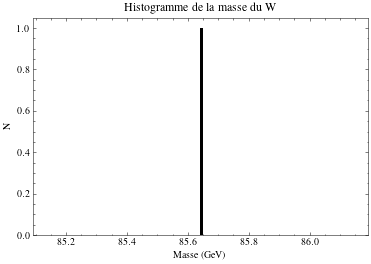

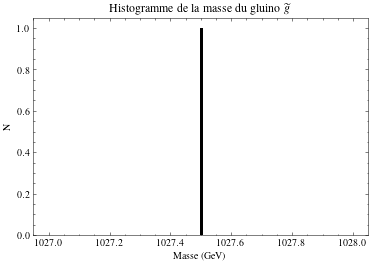

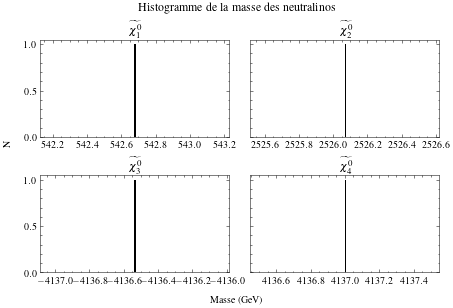

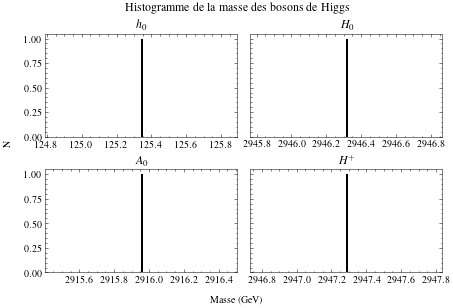

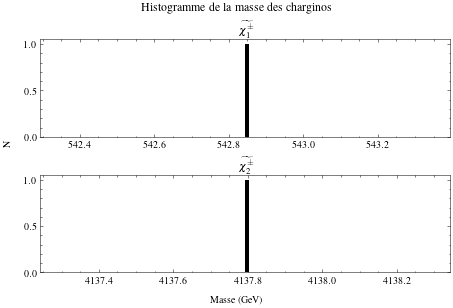

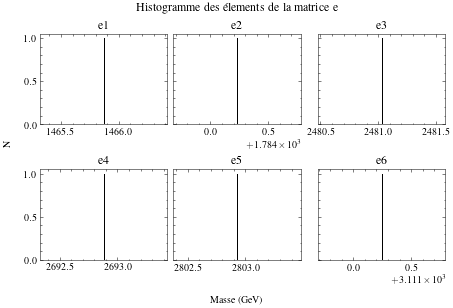

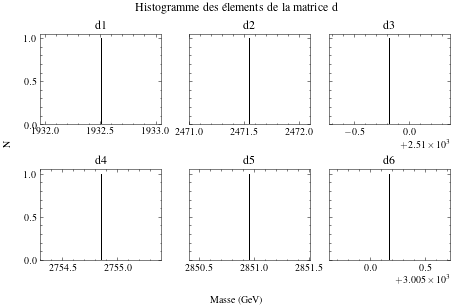

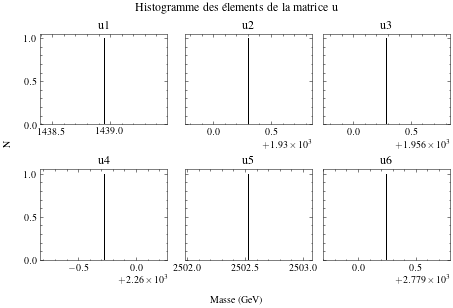

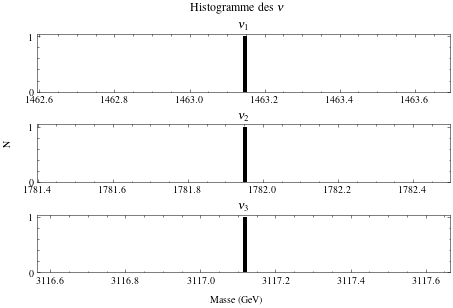

In [12]:
folder = 'Advanced NN/NMFV/NMFV_run/'+folder_name

file = '/histo_W.svg'
titre = r'Histogramme de la masse du W'
xlabel = 'Masse (GeV)'
ylabel = 'N'
plot_histo(titre,xlabel,ylabel,[MW_mass],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_g.svg'
titre = r'Histogramme de la masse du gluino $\widetilde{g}$'
plot_histo(titre,xlabel,ylabel,[g_mass],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_neutralinos.svg'
titre = 'Histogramme de la masse des neutralinos'
subtitle = [r'$\widetilde{\chi_1^0}$',r'$\widetilde{\chi_2^0}$',r'$\widetilde{\chi_3^0}$',r'$\widetilde{\chi_4^0}$']
share = [False,True]
subplot_histo(titre,xlabel,ylabel,2,2,share,subtitle,[neutralino_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_higgs.svg'
titre = 'Histogramme de la masse des bosons de Higgs'    
subtitle = [r'$h_0$',r'$H_0$',r'$A_0$',r'$H^+$']
subplot_histo(titre,xlabel,ylabel,2,2,share,subtitle,[higgs_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_charginos.svg'
titre = 'Histogramme de la masse des charginos'    
subtitle = [r'$\widetilde{\chi_1^\pm}$',r'$\widetilde{\chi_2^\pm}$']
subplot_histo(titre,xlabel,ylabel,2,1,share,subtitle,[chargino_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_e.svg'
titre = 'Histogramme des élements de la matrice e'    
subtitle = ['e1','e2','e3','e4','e5','e6']
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[e_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_d.svg'
titre = 'Histogramme des élements de la matrice d'    
subtitle = ['d1','d2','d3','d4','d5','d6']
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[d_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_e.svg'
titre = 'Histogramme des élements de la matrice u'    
subtitle = ['u1','u2','u3','u4','u5','u6']
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[u_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_nu.svg'
titre = r'Histogramme des $\nu$'    
subtitle = [r'$\nu_1$',r'$\nu_2$',r'$\nu_3$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[nu_mass],['NN'],save=True,file_folder=folder+file)

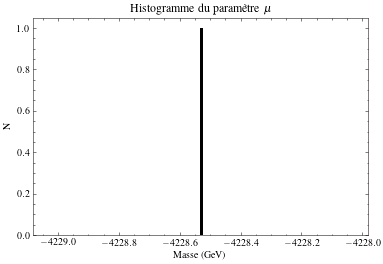

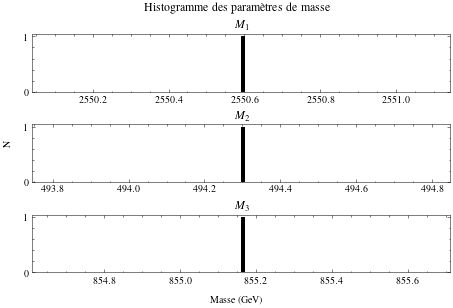

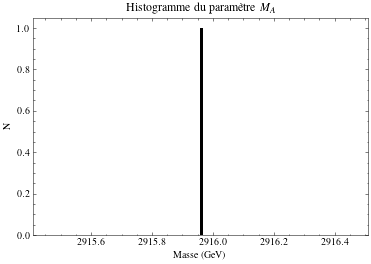

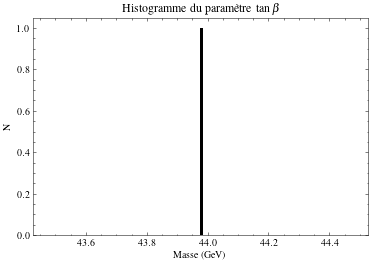

In [13]:
file = '/histo_mu.svg'
titre = r'Histogramme du paramètre $\mu$'
plot_histo(titre,xlabel,ylabel,[mu_param],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_M.svg'
titre = 'Histogramme des paramètres de masse'
subtitle = [r'$M_1$',r'$M_2$',r'$M_3$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[M_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_mA.svg'
titre = r'Histogramme du paramètre $M_A$'
plot_histo(titre,xlabel,ylabel,[mA_param],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_tanb.svg'
titre = r'Histogramme du paramètre $\tan \beta$'
plot_histo(titre,xlabel,ylabel,[tanB_param],100,['NN'],save=True,file_folder=folder+file)

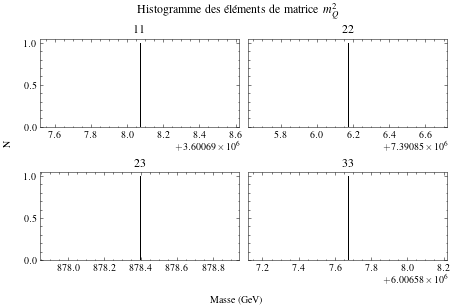

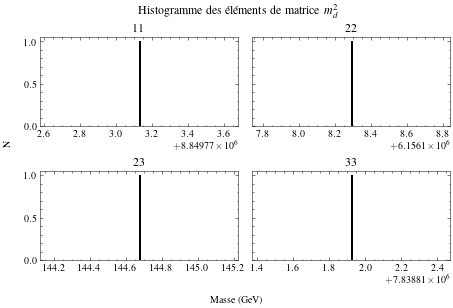

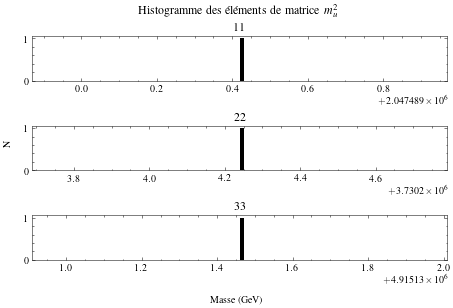

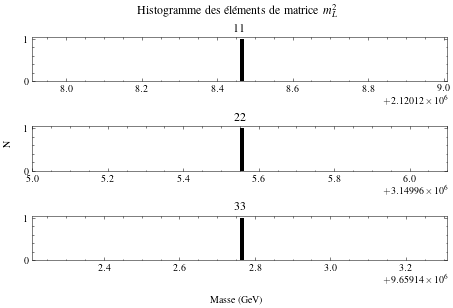

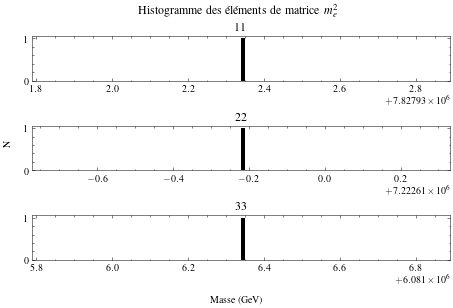

In [14]:
file = '/histo_msq2.pdf'
titre = r'Histogramme des éléments de matrice $m^2_Q$'
subtitle = ['11','22','23','33']
subplot_histo(titre,xlabel,ylabel,2,2,share,subtitle,[msq2_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_msd2.pdf'
titre = r'Histogramme des éléments de matrice $m^2_d$'
subtitle = ['11','22','23','33']
subplot_histo(titre,xlabel,ylabel,2,2,share,subtitle,[msd2_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_msu2.pdf'
titre = r'Histogramme des éléments de matrice $m^2_u$'
subtitle = ['11','22','33']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[msu2_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_msl2.pdf'
titre = r'Histogramme des éléments de matrice $m^2_L$'
subtitle = ['11','22','33']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[msl2_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_mse2.pdf'
titre = r'Histogramme des éléments de matrice $m^2_e$'
subtitle = ['11','22','33']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[mse2_param],['NN'],save=True,file_folder=folder+file)

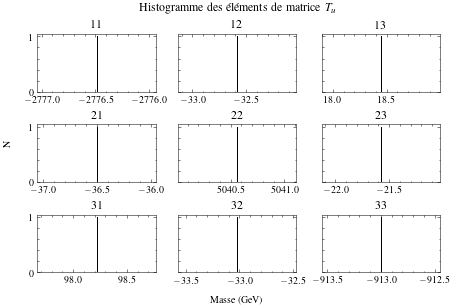

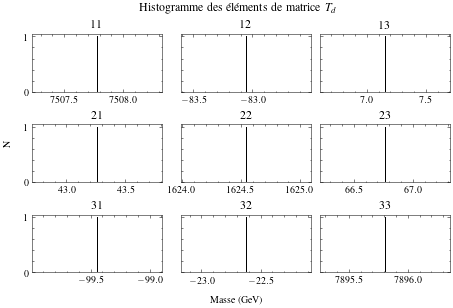

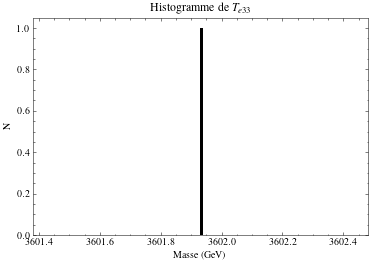

In [15]:
file = '/histo_tu.pdf'
titre = r'Histogramme des éléments de matrice $T_u$'
subtitle = ['11','12','13','21','22','23','31','32','33']
subplot_histo(titre,xlabel,ylabel,3,3,share,subtitle,[tu_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_td.pdf'
titre = r'Histogramme des éléments de matrice $T_d$'
subtitle = ['11','12','13','21','22','23','31','32','33']
subplot_histo(titre,xlabel,ylabel,3,3,share,subtitle,[td_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_te.svg'
titre = r'Histogramme de $T_{e33}$'
plot_histo(titre,xlabel,ylabel,[te_param],100,['NN'],save=True,file_folder=folder+file)

In [16]:
print('Statisique du Neural Network')
print("Nombre d'échecs:",ratio[0])
print("Nombre de succes:",ratio[1])
print('Nombre warning:', warning)
print('Éfficacité du AL:',100*ratio[1]/(ratio[0]+ratio[1]),'%')
print('\n')

Statisique du Neural Network
Nombre d'échecs: 999
Nombre de succes: 1
Nombre warning: 0
Éfficacité du AL: 0.1 %


